# Inital data analysis of the virtual screening results

This notebook does some general data anslysis on the virtual screening results.

It uses the output of the 1_DataPrep.ipynb notebook for it's data. 

In [93]:
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

import os, glob, gzip

In [94]:
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import PandasTools

In [95]:
# Set the default renderer to png as the data is huge and overwhelms the Javascript renderers
pio.renderers.default = 'png'

In [96]:
# Currently can't work out how to read the pickle correctly so we read the SDF instead
df = PandasTools.LoadSDF('./Mpro_16_data.sdf.gz', molColName='Molecule')
df.shape

(41582, 13)

In [97]:
df.dtypes

Target                        object
TransFSScore                  object
SCORE                         object
SCORE.norm                    object
Max_SuCOS_Score               object
Max_SuCOS_FeatureMap_Score    object
Max_SuCOS_Protrude_Score      object
Max_SuCOS_Index               object
Cum_SuCOS_Score               object
Cum_SuCOS_FeatureMap_Score    object
Cum_SuCOS_Protrude_Score      object
ID                            object
Molecule                      object
dtype: object

,Target,TransFSScore,SCORE,SCORE.norm,Max_SuCOS_Score,Max_SuCOS_FeatureMap_Score,Max_SuCOS_Protrude_Score,Max_SuCOS_Index,Cum_SuCOS_Score,Cum_SuCOS_FeatureMap_Score,Cum_SuCOS_Protrude_Score,ID,Molecule
0,Mpro-x0678,0.162173,-14.4733,-1.31576,0.0,0.0,0.0,0,0.0,0.0,0.0,BrC(Br)=Cc1ccc(Br)cc1,
1,Mpro-x0104,0.078375,-30.9106,-3.09106,0.284089,0.024352,0.543826,13,2.078812,0.424377,3.733246,BrC(Br)=Cc1ccncn1,
2,Mpro-x0104,0.076633,-33.4132,-3.34132,0.31792,0.179804,0.456035,2,2.0723,0.394161,3.750438,BrC(Br)=Cc1cncnc1,
3,Mpro-x1249,0.178053,-15.4443,-0.90849,0.434434,0.151883,0.716986,13,3.900913,1.153626,6.648199,BrC(CCC1CCCCC1)Cc1ccccn1,
4,Mpro-x0678,0.431011,-23.7233,-1.39549,0.308991,0.09981,0.518171,8,3.210272,0.57876,5.841785,BrC(CCC1CCCCC1)Cc1ccncc1,

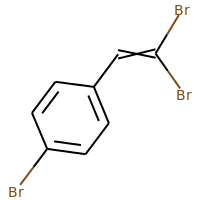
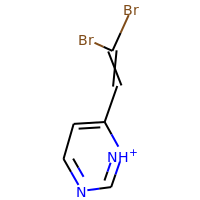
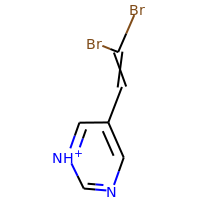
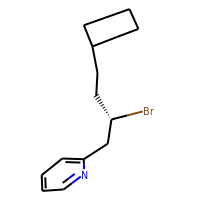
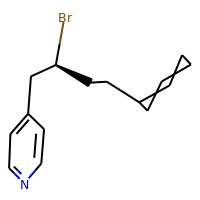

In [98]:
df.head()

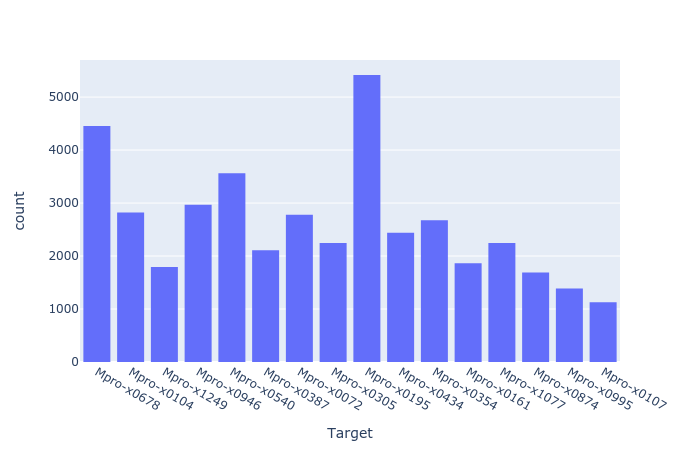

In [99]:
# Let's look at which targets the best TransFSScoring poses came from
fig = px.histogram(df, x="Target")
fig.show()

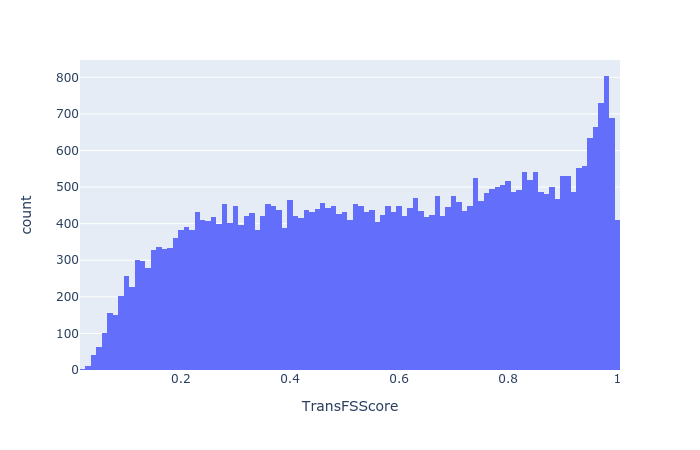

In [100]:
# Let's look at the distribution of TransFSSCores
fig = px.histogram(df, x="TransFSScore")
fig.show()

In [101]:
# Let's look at the distribution of normalised docking scores.
# The more negative the number the better.
fig = px.histogram(df, x="SCORE.norm")
fig.show()

# these cluster around -2 but there are wild outliers

ValueError: 
For some reason plotly.py was unable to communicate with the
local orca server process, even though the server process seems to be running.

Please review the process and connection information below:

orca status
-----------
    state: running
    executable: /home/timbo/miniconda3/envs/jupyter-xchem/bin/orca
    version: 1.3.1
    port: 42041
    pid: 5066
    command: ['/home/timbo/miniconda3/envs/jupyter-xchem/bin/orca', 'serve', '-p', '42041', '--plotly', '/home/timbo/miniconda3/envs/jupyter-xchem/lib/python3.8/site-packages/plotly/package_data/plotly.min.js', '--graph-only', '--mathjax', 'https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js']




In [ ]:
# Let's look at the distribution of Max_SuCOS_Score scores
fig = px.histogram(df, x="Max_SuCOS_Score")
fig.show()
# Susan's rule of thumb is that anything above 0.5 is 'reasonable'.

In [ ]:
# Let's look at the distribution of Cum_SuCOS_Score scores.
# These might be more useful than the Max_SuCOS_Score as it includes overlap with all hit ligands?
fig = px.histogram(df, x="Cum_SuCOS_Score")
fig.show()

In [ ]:
# Let's check the distribution of normalised docking scrores across the targets.
# Low (negative) scores are better.
fig = px.box(df, x="Target", y="SCORE.norm")
fig.show()

In [ ]:
# You can instead use a violin plot for a different view of this
fig = px.violin(df, x="Target", y="SCORE.norm")
fig.show()

In [ ]:
# Now the TransFSScore
fig = px.box(df, x="Target", y="TransFSScore")
fig.show()

In [ ]:
# And the Max_SuCOS_Score
fig = px.box(df, x="Target", y="Max_SuCOS_Score")
fig.show()

In [ ]:
# And the Cum_SuCOS_Score
fig = px.box(df, x="Target", y="Cum_SuCOS_Score")
fig.show()

In [ ]:
# Let's see how the TransFSScore compare with the Cum_SuCOS_Score.
fig = go.Figure(go.Histogram2d(
        x=df['TransFSScore'],
        y=df['Cum_SuCOS_Score']
    ))
fig.show()
# Not much of a correlation. But that's not too surprising and may be good if we use both to filter 
# as they are orthoganal.

In [ ]:
# How about correlation of TransFSScore with normalised docking score
# We need to filter the docking score because of the outliers
filtered_df = df[(df['SCORE.norm'] < 0) & (df['SCORE.norm'] > -3)]
fig = go.Figure(go.Histogram2d(
        x=filtered_df['TransFSScore'],
        y=filtered_df['SCORE.norm']
    ))
fig.show()
# No real correlation visible 

In [ ]:
# How about correlation of Cum_SuCOS_Score with normalised docking score
# We need to filter the docking score because of the outliers
filtered_df = df[(df['SCORE.norm'] < 0) & (df['SCORE.norm'] > -3)]
fig = go.Figure(go.Histogram2d(
        x=filtered_df['Cum_SuCOS_Score'],
        y=filtered_df['SCORE.norm'],
    ))
fig.show()
# No real correlation visible